In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
labels = pd.read_csv(r"C:\Users\bhard\Desktop\Deep_Learning_Project\labels.csv")

In [5]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
				rescale=1./255.,
				horizontal_flip = True,
				validation_split=0.2 # training: 80% data, validation: 20% data
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = r'C:\Users\bhard\Desktop\Deep_Learning_Project\data', # images data path / folder in which images are there
	x_col = 'id',
	y_col = 'class',
	subset="training",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=32,
	shuffle=True,
	seed=42,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = r'C:\Users\bhard\Desktop\Deep_Learning_Project\data', # images data path / folder in which images are there
	x_col = 'id',
	y_col = 'class',
	subset="validation",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=32,
	shuffle=True,
	seed=42,
)

Found 14000 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.


In [7]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

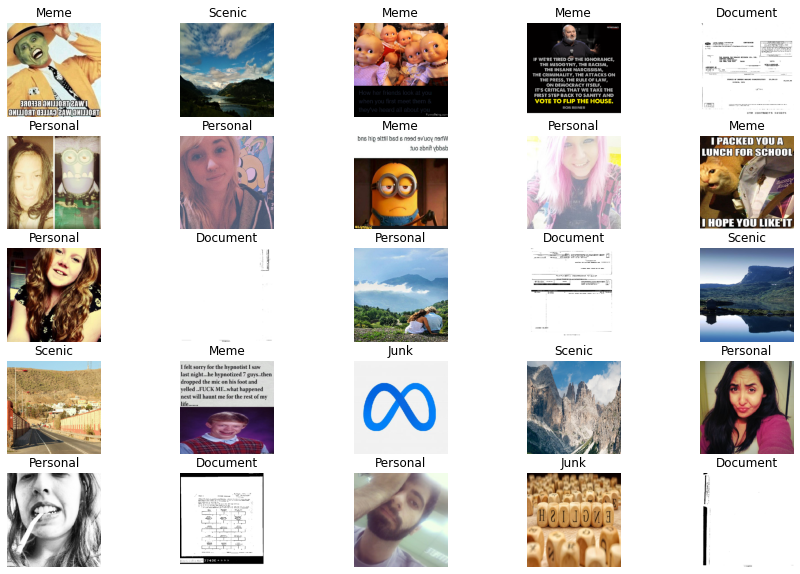

In [8]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
	plt.figure(figsize=[15,10])
	for i in range(25):
		plt.subplot(5,5,i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')
		
plot_images(x,y)

In [9]:
class_names

['Document', 'Junk', 'Meme', 'Personal', 'Scenic']

In [6]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(5, activation='softmax')
	])

In [7]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [9]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back

In [10]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=3,
					callbacks=[early])

Epoch 1/3
437/437 [==============================] - 2271s 5s/step - loss: 0.2206 - accuracy: 0.9263 - val_loss: 0.1341 - val_accuracy: 0.9613
Epoch 2/3
437/437 [==============================] - 2199s 5s/step - loss: 0.1122 - accuracy: 0.9641 - val_loss: 0.1435 - val_accuracy: 0.9584
Epoch 3/3
437/437 [==============================] - 2292s 5s/step - loss: 0.0778 - accuracy: 0.9732 - val_loss: 0.1183 - val_accuracy: 0.9682


In [11]:
model.save("Model.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9731529355049133\nValidation Accuracy: 0.9681766033172607')

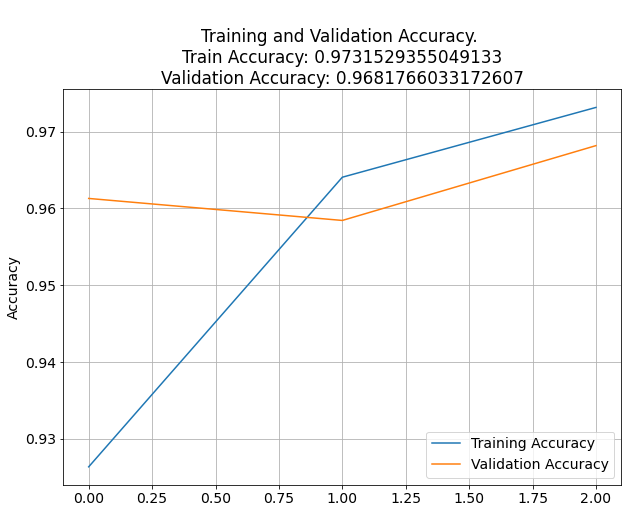

In [16]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f"\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}")

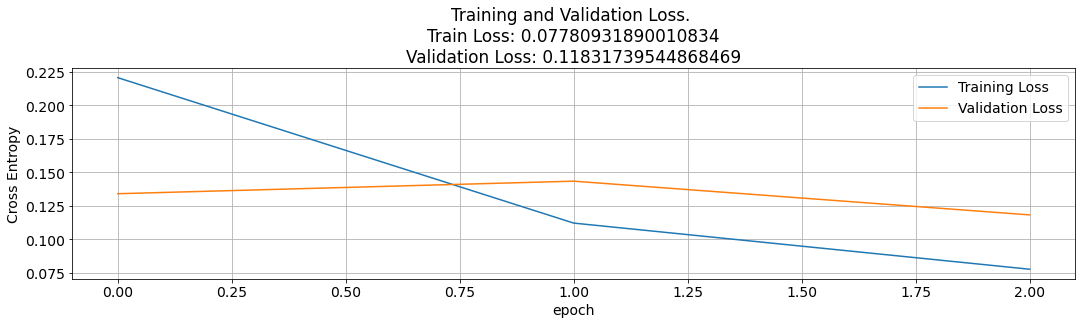

In [18]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

110/110 [==============================] - 440s 4s/step - loss: 0.1165 - accuracy: 0.9689
[0.11646663397550583, 0.9688571691513062]
Accuracy: 96.8857%
Loss:  0.11646663397550583


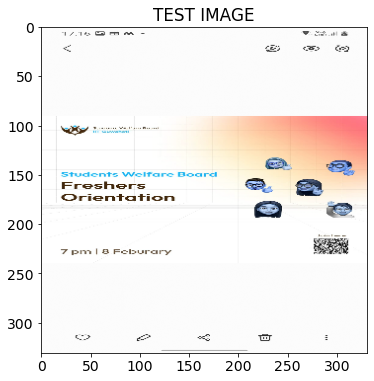

In [60]:
test_img_path = r"C:\Users\bhard\Desktop\or.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.grid(False)
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [61]:
img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)
print(prediction)

[[9.9783053e-04 7.2097176e-01 2.7746987e-01 4.6448968e-04 9.6050149e-05]]


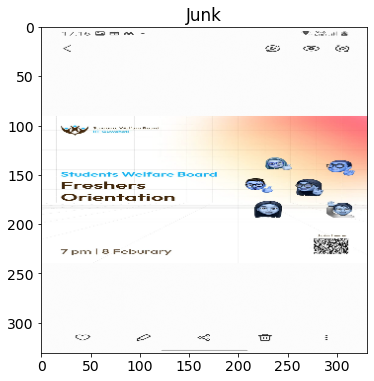

In [62]:
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title(class_names[np.argmax(prediction)])
plt.grid(False)
#plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [26]:
# CREDITS :- https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/